In [1]:
### Important links: 
## https://nicharuc.github.io/topic_modeling/#topic=0&lambda=1&term=
## https://realpython.com/pandas-python-explore-dataset/

In [2]:
# Ignore warnings that refer to upcoming changes in programs
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
# UTILITY CODE:

# This section is important to be able to open large dataframes, redefining the memory limit.
# Be careful not to mess with this as this can drastically affect memory:

# Data matrix and data frame are huge files, these lines are required to open them:
import sys
import csv
maxInt = sys.maxsize

while True:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs
    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)
        
# https://stackoverflow.com/questions/15063936/csv-error-field-larger-than-field-limit-131072

In [4]:
## Import libraries
import spacy
import nltk

# nltk.download('averaged_perceptron_tagger')
import re
import string
import pandas as pd
pd.set_option("display.max.columns", None)
import numpy as np

import gensim
from gensim import corpora
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import json
%matplotlib inline

In [5]:
## Paths
path = './spreadsheets/'
df_nnovels_corpus = 'df_nnovels_full.csv'
df_txtlab_corpus = 'df_txtlab_full.csv'
path_to_assets = './assets/'
stop_all = path_to_assets + 'stopall.txt'
stop_names = path_to_assets + 'stopnames.txt'

with open(stop_all, 'r') as stop_all_o:
    stop_word_list = stop_all_o.read().split()

In [6]:
# FUNCTIONS 1:
# Progress bar to follow up on what's happing while running code:
def progress(count, total, status=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))
    
    #old: percents = round(100.0 * count / float(total), 1)
    percents = round(100.1 * count / float(total), 1)
    bar = '#' * filled_len + '-' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', status))
    sys.stdout.flush()  # As suggested by Rom Ruben (see: http://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console/27871113#novel_text50529068_27871113)

# for metadata output:
def output_metadata(df, spreadsheet_name = 'BLA', path_output = './spreadsheets/'):
    list_of_columns_not_to_include = ['words_standardized_stopped', 'sentences_standardized_stopless','words_as_string_for_vectorizor', 'dirty_text']
    columns_to_include = [column_name for column_name in df.columns.values.tolist() if column_name.lower() not in list_of_columns_not_to_include]
    df_meta = df[columns_to_include]
    df_meta.to_csv(path_output + spreadsheet_name + '.csv')
    print(spreadsheet_name + ' was saved in '+str(path_output))
    
# for full output:
def output_full(df, spreadsheet_name = 'BLA', path_output = './spreadsheets/'):
    df.to_csv(path_output + spreadsheet_name + '.csv')
    print(spreadsheet_name + ' was saved in '+str(path_output))

# for inporting df to pandas
def open_df_and_print(file_name = 'df_full.csv', path_output = './spreadsheets/', drop_first_column=False):
    df = pd.read_csv(path_output + file_name, engine='python')
    if drop_first_column == True:
        df.drop(df.columns[0], axis=1, inplace=True)
    return df

In [7]:
### Cleaning

nlp = spacy.load('en_core_web_sm')
nlp.max_length = 2069077
STOPWORDS_DICT = {lang: set(nltk.corpus.stopwords.words(lang)) for lang in nltk.corpus.stopwords.fileids()}


def clean_all(df, col_name):
    """
    Combines all functions used to clean and lemmatize the comments.
    :param df: data frame with comments
    :param col_name: column name in data frame containing comments
    :return: data frame with comments column lemmatized
    """

    # encode for only ascii characters
    df[col_name] = df[col_name].map(ascii_rm)
    print("finished getting ascii only chars")
    # lowercase texts
    df[col_name] = df[col_name].map(lambda x: x.lower())
    print("finished lowercasing")

    # lemmatize words
    df[col_name] = df[col_name].astype(str).map(lemma)
    print("finished lemmatizing")
    # remove punctuation
    df[col_name] = df[col_name].map(punc_n)
    print("finished removing punctuation")

    # filter only english comments/non blank comments
    # df['language'] = df[col_name].map(get_language)
    # df = df.loc[df['language'] == 'english']
    # df = df.drop('language', axis=1)
    # df = df[df[col_name] != ""]
    
    return df


def ascii_rm(comment):
    """
    Parses comments and keep only ascii characters
    :param comment: a comment
    :return: comment with only ascii characters
    """
    comment = comment.encode('ascii', errors = 'ignore')
    return comment

def get_language(text):
    """
    Determines what language the comment is written in and filters only English comments.
    :param text: comment
    :return: language of comment
    """
    words = set(nltk.wordpunct_tokenize(text.lower()))
    return max(((lang, len(words & stopwords)) for lang, stopwords in STOPWORDS_DICT.items()), key = lambda x: x[1])[0]


def punc_n(comment):
    """
    Removes punctuations from comments.
    :param comment: a comment
    :return: comment without punctuations
    """
    regex = re.compile('[' + re.escape('!"#%&\'()*+,-./:;<=>?@[\\]^_`{|}~')+'0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", comment)
    nopunct_words = nopunct.split(' ')
    filter_words = [word.strip() for word in nopunct_words if word != '']
    words = ' '.join(filter_words)
    return words



def lemma(comment):
    """
    Lemmatize comments using spacy lemmatizer.
    :param comment: a comment
    :return: lemmatized comment
    """
    lemmatized = nlp(comment)
    lemmatized_final = ' '.join([word.lemma_ for word in lemmatized if word.lemma_ != '\'s'])
    return lemmatized_final

In [8]:
### Load the data
df_nnovels_full = open_df_and_print(file_name = df_nnovels_corpus, path_output = path, drop_first_column=True)
df_nnovels_full.head()

,book_title,book_year,author_name,words_standardized_stopped,sentences_standardized_stopless,words_count_stopless,words_count_stopped,percentage_stopped_of_stoppless,sentences_count,average_words_per_sentence,words_as_string_for_vectorizor,full_text_ttr,mattr_500,mattr_2000,all_pos_counts,50_most_common_nouns,50_most_common_verbs,POS_PUNCT,POS_NOUN,POS_DET,POS_ADJ,POS_VERB,POS_SCONJ,POS_ADP,POS_AUX,POS_PART,POS_CCONJ,POS_ADV,POS_PROPN,POS_PRON,POS_NUM,POS_INTJ,POS_X,noun_percentage,verb_and_aux_percentage,POS_SYM,parts_of_speech_total_count,%POS_PUNCT,%POS_NOUN,%POS_DET,%POS_ADJ,%POS_VERB,%POS_SCONJ,%POS_ADP,%POS_AUX,%POS_PART,%POS_CCONJ,%POS_ADV,%POS_PROPN,%POS_PRON,%POS_NUM,%POS_INTJ,%POS_X,%POS_SYM
0,Agnes_Grey,1847,Anne_Bronte,"['\ufeffchapter', 'parsonage', 'true', 'histor...","['\ufeffchapter i', ' the parsonage all true h...",67718.0,24161.0,35.678845,3201.0,21.175258,﻿chapter i. the parsonage all true histories c...,0.108841,0.519898,0.368708,"[['PUNCT', 4930], ['NOUN', 10116], ['DET', 825...","[('time', 142), ('mother', 124), ('day', 65), ...","[('would', 379), ('could', 260), ('said', 186)...",4930.0,10116.0,8255.0,4864.0,10808.0,2000.0,6730.0,3776.0,2632.0,3931.0,5084.0,2033.0,8228.0,357.0,277.0,37.0,13.660,14.594,0.0,74058.0,6.657,13.660,11.147,6.568,14.594,2.701,9.087,5.099,3.554,5.308,6.865,2.745,11.110,0.482,0.374,0.050,0.000
1,Armadale,1864,Wilkie_Collins,"['\ufeffi', 'travelers', 'opening', 'season', ...","['\ufeffi', ' the travelers', ' it was the ope...",295546.0,111234.0,37.636781,19298.0,15.344647,﻿i. the travelers. it was the opening of the s...,0.045656,0.497521,0.341371,"[['ADP', 36354], ['PUNCT', 20620], ['DET', 436...","[('time', 864), ('midwinter', 786), ('man', 70...","[('said', 1136), ('will', 694), ('would', 578)...",20620.0,52174.0,43605.0,18284.0,44704.0,6609.0,36354.0,16230.0,9975.0,9477.0,17419.0,12346.0,32389.0,1712.0,541.0,25.0,16.180,13.863,0.0,322464.0,6.395,16.180,13.522,5.670,13.863,2.050,11.274,5.033,3.093,2.939,5.402,3.829,10.044,0.531,0.168,0.008,0.000
2,Aurora_Floyd,1863,Mary_Elizabeth_Braddon,"['rich', 'banker', 'married', 'actress', 'fain...","['chapter i', ' how a rich banker married an a...",183016.0,74878.0,40.913363,9425.0,19.422599,chapter i. how a rich banker married an actres...,0.075907,0.529468,0.381519,"[['PROPN', 9662], ['ADV', 10206], ['DET', 2736...","[('man', 506), ('face', 245), ('time', 233), (...","[('said', 562), ('would', 553), ('could', 449)...",10576.0,33566.0,27368.0,13795.0,25284.0,5435.0,20867.0,9771.0,4237.0,7753.0,10206.0,9662.0,15633.0,1101.0,394.0,56.0,17.151,12.919,2.0,195706.0,5.404,17.151,13.984,7.049,12.919,2.777,10.662,4.993,2.165,3.962,5.215,4.937,7.988,0.563,0.201,0.029,0.001
3,Belinda:A_Novel,1883,Rhoda_Broughton,"['crisped', 'shades', 'bowers', 'revels', 'spr...","['chapter i', ' along the crisped shades and b...",147937.0,57386.0,38.790837,10248.0,14.100898,chapter i. along the crisped shades and bowers...,0.092824,0.534271,0.384540,"[['PROPN', 5341], ['ADP', 14886], ['DET', 1801...","[('eyes', 227), ('voice', 212), ('one', 175), ...","[('says', 577), ('will', 562), ('would', 431),...",11552.0,23275.0,18018.0,10336.0,20488.0,4025.0,14886.0,9313.0,4134.0,4949.0,10799.0,5341.0,15702.0,908.0,444.0,125.0,15.085,13.278,0.0,154295.0,7.487,15.085,11.678,6.699,13.278,2.609,9.648,6.036,2.679,3.207,6.999,3.462,10.177,0.588,0.288,0.081,0.000
4,Birds_of_Prey,1867,Mary_Elizabeth_Braddon,"['house', 'bloomsbury', 'houses', 'whereof', '...","['chapter i', ' the house in bloomsbury', ' wh...",161547.0,64208.0,39.745709,8357.0,19.335168,chapter i. the house in bloomsbury. what about...,0.083881,0.526442,0.376160,"[['PROPN', 8773], ['DET', 23096], ['ADP', 1857...","[('man', 426), ('time', 269), ('life', 233), (...","[('would', 490), ('said', 422), ('could', 327)...",9019.0,29719.0,23096.0,12741.0,21333.0,4212.0,18573.0,9380.0,4281.0,6808.0,8960.0,8773.0,13952.0,1085.0,427.0,46.0,17.238,12.374,0.0,172405.0,5.231,17.238,13.396,7.390,12.374,2.443,10.773,5.441,2.483,

In [9]:
### Extract only cleaned text
clean_text = pd.DataFrame(df_nnovels_full.words_as_string_for_vectorizor)
clean_text = clean_all(clean_text, 'words_as_string_for_vectorizor')

finished getting ascii only chars
finished lowercasing
finished lemmatizing
finished removing punctuation


In [10]:
clean_text.head()

,words_as_string_for_vectorizor
0,b chapter i the parsonage all true history con...
1,b i the traveler it be the opening of the seas...
2,b chapter i how a rich banker marry an actress...
3,b chapter i along the crisped shade and bower ...
4,b chapter i the house in bloomsbury what about...


In [ ]:
output_full(clean_text, spreadsheet_name = 'clean_text_nnovels_for_tm', path_output = './spreadsheets/'):

In [11]:
## Form Bigrams and Trigrams for better topics


bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([novel_text.split() for novel_text in clean_text.words_as_string_for_vectorizor])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)



In [12]:


trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([novel_text.split() for novel_text in clean_text.words_as_string_for_vectorizor])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)



In [13]:


bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)



In [14]:


trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)



In [15]:
# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stop_word_list or bigram[1] in stop_word_list:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

In [16]:


# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stop_word_list or trigram[-1] in stop_word_list or trigram[1] in stop_word_list:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    if 'PRON' in trigram:
        return False
    return True 



In [17]:


# Can set pmi threshold to whatever makes sense - eyeball through and select threshold where n-grams stop making sense
# choose top 500 ngrams in this case ranked by PMI that have noun like structures
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 5, axis = 1)][:500]

filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                                 trigram_filter(trigram['trigram'])\
                                                 and trigram.pmi > 5, axis = 1)][:500]


bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]



In [18]:


# examples of bigrams
bigrams[:10]



['kirylo sidorovitch',
 'councillor mikulin',
 'san francisco',
 'otway bethel',
 'reb shemuel',
 'lu cretia',
 'granville varney',
 'gilbert arnold',
 'rosanna spearman',
 'thorpe ambrose']

In [19]:
# examples of trigrams
trigrams[:10]

['mme de brecourt',
 'madame max goesler',
 'leicester dedlock baronet',
 'lord mount severn',
 'madame de castella',
 'sir rupert lisle',
 'sir leicester dedlock',
 'mr godfrey ablewhite',
 'mr ben allen',
 'carleton st john']

In [20]:
# Concatenate n-grams
def replace_ngram(x):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

In [21]:
novels_w_ngrams = clean_text.copy()

In [22]:
novels_w_ngrams.words_as_string_for_vectorizor = novels_w_ngrams.words_as_string_for_vectorizor.map(lambda x: replace_ngram(x))

In [23]:


# tokenize reviews + remove stop words + remove names + remove words with less than 2 characters
novels_w_ngrams = novels_w_ngrams.words_as_string_for_vectorizor.map(lambda x: [word for word in x.split()\
                                                 if word not in stop_word_list\
                                                              and len(word) > 2])



In [24]:
novels_w_ngrams.head()

0    [parsonage, true, history, instruction, treasu...
1    [traveler, opening, season, eighteen_hundred, ...
2    [rich, banker, marry, actress, faint, streak, ...
3    [crisped, shade, bower, revel, spruce, jocund,...
4    [house, bloomsbury, house, whereof, outward, a...
Name: words_as_string_for_vectorizor, dtype: object

In [25]:


# Filter for only nouns
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered



In [26]:
final_texts = novels_w_ngrams.map(noun_only)

In [27]:
### LDA Model Begins

In [28]:
dictionary = corpora.Dictionary(final_texts)

In [29]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_texts]

In [32]:
output_full(clean_text, spreadsheet_name = 'clean_text_nnovels_for_tm', path_output = './spreadsheets/')

clean_text_nnovels_for_tm was saved in ./spreadsheets/


In [33]:


coherence = []
for k in range(5,25):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=40,\
                   iterations=200, chunksize = 10000, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=final_texts,\
                                                     dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))



Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Round: 21
Round: 22
Round: 23
Round: 24


In [34]:


x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]



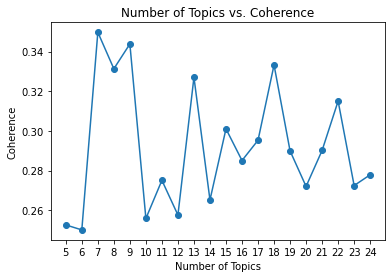

In [35]:


plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()



In [44]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=7, id2word = dictionary, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

In [45]:
Lda2 = gensim.models.ldamodel.LdaModel
ldamodel2 = Lda2(doc_term_matrix, num_topics=18, id2word = dictionary, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

In [46]:
# To show initial topics from model 1
ldamodel.show_topics(7, num_words=10, formatted=False)

[(0,
  [('time', 0.010212081),
   ('man', 0.009682939),
   ('hand', 0.008036973),
   ('room', 0.007153036),
   ('day', 0.0064843874),
   ('house', 0.006272605),
   ('word', 0.0060043517),
   ('face', 0.0057726875),
   ('lady', 0.0053385687),
   ('place', 0.005097196)]),
 (1,
  [('man', 0.01601532),
   ('time', 0.007796375),
   ('hand', 0.0072043645),
   ('day', 0.0064138905),
   ('eye', 0.0057960413),
   ('woman', 0.0055345437),
   ('thing', 0.0053966916),
   ('word', 0.0052577113),
   ('sir', 0.005087649),
   ('face', 0.0045181387)]),
 (2,
  [('man', 0.011189123),
   ('time', 0.00784052),
   ('hand', 0.0074046804),
   ('eye', 0.0071308427),
   ('day', 0.0064485287),
   ('thing', 0.006444632),
   ('life', 0.0053417184),
   ('face', 0.0052340683),
   ('word', 0.004840793),
   ('heart', 0.004124696)]),
 (3,
  [('man', 0.01134396),
   ('time', 0.010526113),
   ('hand', 0.008987271),
   ('day', 0.0067716925),
   ('eye', 0.006567237),
   ('face', 0.0062793843),
   ('house', 0.0055301078),
 

In [47]:
# To show initial topics from model 2
ldamodel2.show_topics(18, num_words=10, formatted=False)

[(0,
  [('meg', 0.012608852),
   ('barbara', 0.012143272),
   ('man', 0.009333887),
   ('mr_carlyle', 0.008412447),
   ('hand', 0.008134595),
   ('time', 0.0073347134),
   ('day', 0.0073023485),
   ('room', 0.006720655),
   ('face', 0.0062940116),
   ('lady_isabel', 0.0061152317)]),
 (1,
  [('man', 0.022538545),
   ('day', 0.009210086),
   ('word', 0.008670344),
   ('thing', 0.0084698135),
   ('house', 0.008060118),
   ('time', 0.007519594),
   ('money', 0.00719919),
   ('belinda', 0.006997377),
   ('hand', 0.0069142426),
   ('vavasor', 0.006292954)]),
 (2,
  [('shirley', 0.0068209763),
   ('man', 0.0067065377),
   ('time', 0.0063099274),
   ('day', 0.0059188996),
   ('hand', 0.0056586456),
   ('eye', 0.0054651066),
   ('heart', 0.004257816),
   ('life', 0.0037450895),
   ('sit', 0.0037373828),
   ('thing', 0.0037359651)]),
 (3,
  [('time', 0.012561114),
   ('man', 0.010220521),
   ('hand', 0.008726439),
   ('day', 0.0075557064),
   ('room', 0.007142881),
   ('house', 0.0071363263),
  

In [53]:
topic_data =  pyLDAvis.gensim.prepare(ldamodel2, doc_term_matrix, dictionary, mds = 'pcoa')
pyLDAvis.display(topic_data)

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [51]:
all_topics = {}
num_terms = 10 # Adjust number of words to represent each topic
lambd = 0.6 # Adjust this accordingly based on tuning above
for i in range(1,8): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

In [52]:
pd.DataFrame(all_topics).T

,0,1,2,3,4,5,6,7,8,9
Topic 1,time,man,hand,face,eye,day,room,house,woman,head
Topic 2,man,eye,thing,hand,time,day,life,face,heart,word
Topic 3,man,belinda,vavasor,mr_weller,time,reply,sir,hand,day,gentleman
Topic 4,allan,jude,midwinter,man,dorothea,lydgate,time,rosamond,woman,bulstrode
Topic 5,phinea,mr_pecksniff,man,tom,razumov,finn,mr_kennedy,madame_goesler,jona,pecksniff
Topic 6,meg,barbara,mr_carlyle,audley,lady_isabel,betteredge,joyce,talboy,diamond,time
Topic 7,guy,hagar,manston,cytherea,mrs_edmonstone,crawford,aldclyffe,miss_crawford,edmonstone,amabel


In [ ]:
# output_full(clean_text_nnovels_for_tm, spreadsheet_name = 'clean_text_nnovels_for_tm', path_output = './spreadsheets/')

In [ ]:
# https://stackoverflow.com/questions/66621708/filter-extreme-in-gensim
# Dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)